> 1. 사이버캠퍼스에 올린 뉴스기사 데이터(newsdata.csv)에 대해 형태소 분석 후 json 형태의 파일로 저장하세요.
    - newsdata.csv데이터 안의 news 열에 대해서만 형태소 분석
    - 형태소분석기: 트위터 분석기 사용
    - 출력 파일명: pos_newsdata.txt 

In [1]:
#input_file_name = r"newsdata.csv"
#with open(input_file_name, "r", encoding = "utf-8-sig") as input_file:
#    for line in input_file:
#        print(line)

In [9]:
"""형태소 분석 후 JSON 형태로 파일 저장"""
import csv
import re
import ujson
from konlpy.tag import Twitter

"""문서를 문장 단위로 토큰화"""
def split_sentences(text):
    text = text.strip().replace(". ", ".\n").replace("? ", "?\n").replace("! ", "!\n")
    sentences = text.splitlines()
    return sentences

""" 형태소 분석 실행 """
def get_pos(analyzer, text): 
    morph_anals = []
    sentences = split_sentences(text)       
    for sentence in sentences:
        morph_anal = analyzer.pos(sentence) 
        morph_anals.append(morph_anal)
    return morph_anals

""" def(1): CSV 파일 불러들이기 """
def read_text(input_file_name):
    key_names = ['doc_id', 'date', 'news']
    data = []
    with open(input_file_name, "r", encoding="utf-8-sig",newline="") as input_file:
        reader = csv.reader(input_file)
        for row_num, row in enumerate(reader): 
            #print(row)
            if row_num == 0:  # 첫번째줄 skip
                continue
            news = {}
            for key_name, val in zip(key_names, row):
                news[key_name] = val
            data.append(news)  
    return data  

"""def(2): 주어진 상품평 파일에서 "news"에 대해서만 형태소 분석""" 
# data 넣어주면 data 값에 news_pos 라는 변수 추가해서 데이터셋 출력해줌 
# 형태 : [{'doc_no': '1', 'news': '마지막에 황정민vs유아인 격투....였다. 진짜... ,', 'label': 'pos', 'news_pos': [[('마지막', 'Noun'), 
def pos_news(data): 
    data_pos = []
    twitter = Twitter()
    for newsdata in data:   
        body = newsdata["news"]                 
        #print(body)
        news_pos = get_pos(twitter, body)     
        newsdata["news_pos"] = news_pos         
        data_pos.append(newsdata)   # data_pos.append(news_pos):새로운 변수만 들어감,data_pos.append(newsdata):새로운변수인news_pos들어감
        #print(data_pos)                          
    return data_pos                               

"""def(3): json 형태로 파일 저장"""
def write_pos_review(output_file_name, data_pos):
    with open(output_file_name, "w", encoding="utf-8") as output_file: 
        for news_pos in data_pos:
            news_str = ujson.dumps(news_pos, ensure_ascii=False)
            print(news_str, file=output_file)

""" 앞에서 정의해 준 파일 넣어주면 형태소분석 포함된 변수를 JSON 파일로 저장해줌 """
def main():   # input, output 설정한다음에 하나씩 부르기 
    input_file_name = r"newsdata.csv"
    output_file_name = r"mynewsdata.txt"
    
    data = read_text(input_file_name)     
    #print(data)
    data_pos = pos_news(data)     
    #print(data_pos)
    write_pos_review(output_file_name, data_pos)     
    print(data_pos[0])
    
main()

C:\Users\jeeyeon\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


{'doc_id': '1', 'date': '20140113', 'news': '한국은행은 금융위기 이후 가계가 현재소비를 줄이고 미래에 대비하고 있고, 이는 최근 소비부진의 원인 중 하나라고 분석했다.', 'news_pos': [[('한국은행', 'Noun'), ('은', 'Josa'), ('금융위기', 'Noun'), ('이후', 'Noun'), ('가계', 'Noun'), ('가', 'Josa'), ('현재', 'Noun'), ('소비', 'Noun'), ('를', 'Josa'), ('줄', 'Noun'), ('이고', 'Josa'), ('미래', 'Noun'), ('에', 'Josa'), ('대비', 'Noun'), ('하고', 'Josa'), ('있고', 'Adjective'), (',', 'Punctuation'), ('이는', 'Verb'), ('최근', 'Noun'), ('소비', 'Noun'), ('부진', 'Noun'), ('의', 'Josa'), ('원인', 'Noun'), ('중', 'Noun'), ('하나', 'Noun'), ('라고', 'Josa'), ('분석', 'Noun'), ('했다', 'Verb'), ('.', 'Punctuation')]]}


> 2. 뉴스기사에 대해 형태소 분석 후 주요 품사의 형태소만 선택한 뒤 빈도 역순으로 정렬한 뒤 상위 빈도 100개의 형태소에 대해서만 형태소, 빈도 수 파일 값만 저장하세요.
    - 주요 품사: "Noun", "Verb", "Adverb", "Adjective"
    - 출력 파일명: counts100_newsdata.txt

In [10]:
from collections import Counter
import ujson
from operator import itemgetter # 추가 

POS_KEY = "news_pos"
FEATURE_POS = ["Noun", "Verb", "Adverb", "Adjective"]

"""주어진 품사의 주요 품사 여부(FEATURE_POS)를 판단하여 돌려준다."""
# pos 값이 FEATURE_POS 안에 있으면 TRUE return
def is_feature_pos(pos):  
    if pos in FEATURE_POS:  
        return True
    return False

"""주어진 형태소 분석 결과 리스트에서 필요한 형태소만 골라서 돌려준다."""
# 위에서 정의한 is_feature_pos를 이용해 관심있는 pos 에 대해서만 해당 값의 word 와 함께 return 
def feature_pos(pos_anals):  
    pos_anals = [(word, pos) for word, pos in pos_anals if is_feature_pos(pos)]
    return pos_anals

"""한국어 상품평의 주요 품사 형태소 빈도를 계수한다."""
def main():      
    pos_freq = Counter()
    input_file_name = r"mynewsdata.txt"
    output_file_name = r"counts100_mynewsdata.txt"

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            doc = ujson.loads(line)  
            #print(doc)
            for sent_ma in doc[POS_KEY]:
                sent_ma = feature_pos(sent_ma)
                pos_freq.update(sent_ma)
                
    for (word, pos), freq in pos_freq.most_common(100): 
        print("{}\t{}\t{}".format(word, pos, freq))

main()

소득	Noun	1306
가계	Noun	994
했다	Verb	922
증가	Noun	810
것	Noun	768
기업	Noun	627
등	Noun	587
소비	Noun	493
있다	Adjective	427
정부	Noun	399
하는	Verb	390
수	Noun	376
대출	Noun	368
할	Verb	329
가계부채	Noun	328
로	Noun	326
이	Noun	316
금융	Noun	313
배당	Noun	312
고	Noun	307
금리	Noun	285
투자	Noun	285
평균	Noun	284
율	Noun	277
경제	Noun	275
말	Noun	268
정책	Noun	251
지출	Noun	238
대비	Noun	237
지난해	Noun	232
임금	Noun	230
증대	Noun	223
세제	Noun	221
주택	Noun	215
확대	Noun	202
가구	Noun	201
비중	Noun	185
수준	Noun	183
있는	Adjective	180
기준	Noun	180
경기	Noun	179
해	Verb	178
된다	Verb	177
한다	Verb	177
자금	Noun	175
한국	Noun	175
성장	Noun	174
대한	Noun	170
포인트	Noun	169
감소	Noun	166
은	Noun	164
상승	Noun	164
됐다	Verb	163
비	Noun	161
같은	Adjective	156
상환	Noun	155
이후	Noun	149
부채	Noun	149
된	Verb	149
비율	Noun	145
부담	Noun	144
세	Noun	139
올해	Noun	139
연구원	Noun	139
중	Noun	138
전망	Noun	138
효과	Noun	137
규모	Noun	135
이상	Noun	134
때문	Noun	132
과세	Noun	131
며	Noun	126
를	Noun	126
발표	Noun	125
더	Noun	124
한국은행	Noun	123
영향	Noun	123
년	Noun	123
위해	Noun	121
지난	Noun	118
될	Verb	117
하락	Noun	116
부동산	Noun	115


> 3. 뉴스데이터의 상위 빈도 100개 형태소에 대해서 워드 클라우드로 시각화한 후 시각화한 그림을 저장하세요. 
    - 출력 파일명: news_wordcloud.png

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

input_file_name = r"counts100_newsdata.txt"

with open(input_file_name, "r", encoding="euc-kr") as input_file:
    keywords = {} 
    for line in input_file:
        line = line.rstrip().split("\t") # 문장 단위로 분리해주고
        word, pos, freq = line           # word, freq 변수 만들어주고 
        keywords[word] = int(freq)       # keywords 라는 dic 에는 {word() : frequence}
        
font_path = 'c:\\windows\\fonts\\NanumSquareRoundL.ttf'   # 폰트 경로 지정하기 
wordcloud = WordCloud(font_path = font_path,width = 800, height = 800, background_color="white")  

wordcloud = wordcloud.generate_from_frequencies(keywords) # 형태소와 빈도로 지정된 사전형 자료를 넣어주고 

fig = plt.figure(figsize=(12,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()  # 그래프보여주시오 

fig.savefig('myword_cloud_white.png') # 파일저장하기 

<Figure size 1200x900 with 1 Axes>

## TF-IDF 

In [12]:
"""형태소 분석 후 파일을 불러와 TF 기반의 term-document matrix 생성"""
from operator import itemgetter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import ujson

FEATURE_POS = ["Noun", "Verb", "Adverb", "Adjective", "Exclamation", "Determiner"]
POS_KEY = "news_pos"

"""file_name에 지정해준 파일을 읽은 후 CountVectorizer 에 입력할 파일 형태로 document set 생성"""
def read_documents(input_file_name):
    documents = []
    with open(input_file_name, "r", encoding = "utf-8") as input_file:
        for line in input_file:
            json_obj = ujson.loads(line)  # line 을 load
            text_pos = json_obj[POS_KEY]  # 위에서 POS_KEY 지정해 준 열 가져와서 text_pos로 지정해 놓음 
            
            words = []
            for sent_pos in text_pos:
                for word, pos in sent_pos:
                    if pos not in FEATURE_POS:  # 원하는 품사 가진 단어만 출력 
                        continue
                    words.append(word)          # pos 말고 word만 저장한 words 리스트 저장 
            document = " ".join(words)          # 만들어놓은 words 리스트를 " " 기준으로 join
            documents.append(document)          # 최종적으로 documents 에 저장 
    documents = np.asarray(documents)            # asarray 형태로 변경 
    return(documents)


"""TF 기반의 term-document matrix 생성해서 TSV 파일 형태로 저장"""
def main():
    # 파일 지정 
    input_file_name = r"mynewsdata.txt"
    output_file_name = "tfidf_pos_news.txt"
    documents = read_documents(input_file_name)  # input 데이터 읽어줘라 
    
    vectorizer = TfidfVectorizer(tokenizer = str.split, max_features = 100)    # max_features 최대 100개의 feature만 선택가능
    doc_term_mat = vectorizer.fit_transform(documents)
    
    ## 파일저장
    with open(output_file_name, "w", encoding = "utf-8") as output_file:
        
        doc_num = len(doc_term_mat.toarray())
        for i in range(doc_num):
            for j in doc_term_mat[i]:
                for i1,j in zip(j.indices, j.data):
                    print("{}\t{}\t{}".format(i, vectorizer.get_feature_names()[i1], j), file = output_file)
                    #print(i,vectorizer.get_feature_names()[i1],j)
main()

## Word Cloud

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 파일 불러들이고 word 빼기 
input_file_name = r"tfidf_pos_news.txt"
with open(input_file_name, "r", encoding = "utf-8") as input_file:
    keywords = {}
    for line in input_file:
        line = line.rstrip().split("\t")
        doc, word, tf_idf = line
        keywords[word] = float(tf_idf)
print(keywords)

{'한국은행': 0.08621561878865709, '이후': 0.16783336763312173, '가계': 0.0527714586043907, '현재': 0.10141828367643377, '소비': 0.19519672132786725, '대비': 0.32475078476519453, '중': 0.24478237878897363, '분석': 0.24260135192118643, '했다': 0.2821342074844253, '한': 0.3046914927544526, '은': 0.08215641717409786, '증가': 0.1165021770888843, '율': 0.4229602499959858, '성장': 0.4389467970565954, '률': 0.4145489968766914, '등': 0.11011981540907281, '며': 0.19536002975099, '하는': 0.13833080990644156, '할': 0.07501920811280972, '수': 0.14486337692207057, '있다': 0.13694826400446763, '고': 0.2917176123583173, '위해': 0.3291205668274545, '소득': 0.26183782150084983, '경우': 0.1597259161840839, '된다': 0.3155151359020973, '지난': 0.08745359328254713, '로': 0.0703437599091768, '상승': 0.18932147226159934, '같은': 0.2855536915864488, '기간': 0.31265441093832286, '것': 0.10750242972970443, '수준': 0.18160653054739184, '경제': 0.16707679376921697, '대한': 0.19726279342136796, '개선': 0.10614891420220582, '한다': 0.35263919371017055, '전망': 0.1016750147301928, 

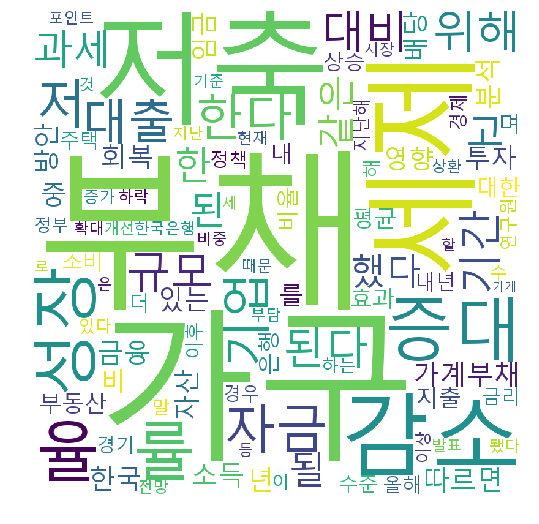

In [14]:
# 워드클라우드 배경 설정
font_path = 'C:\\Windows\\Fonts\\malgun.ttf' 
#wordcloud = WordCloud()
wordcloud = WordCloud(font_path = font_path, width = 800, height = 800, background_color = "white")

# 실행 
wordcloud = wordcloud.generate_from_frequencies(keywords)

fig = plt.figure(figsize = (12,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

fig.savefig('newsdata_word_cloud.png')